 # Comparison of GFlowNets with MCMC methods in 2D for the 4-simplex.

 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
import glob
from pathlib import Path
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math

ROOT_DIR = os.path.abspath("__file__" + "/../../")
sys.path.insert(0, f"{ROOT_DIR}")

In [6]:
from src.MCMC import MCMC

## IMPORTANT

The reward function should return an array of dimensions given by the corresponding `dimensions` of length `gridLength`.

In [7]:
# Suggested rewardFunction. Feel free to use your own.

def rewardFunction(gridLength):
    reward = np.empty(shape=(gridLength, gridLength))
    for i in range(gridLength):
        for j in range(gridLength):    
            reward[i,j] = (i+j)+int(round(gridLength/2.0))/float(i*j+int(round(gridLength/2.0))) 
            
    return reward

In [8]:
iterationsNumber = 5*10**4
batchSize = iterationsNumber / 10
burnFactor = 100
deviation = 0.8
gridLength = 10

drawsFolderBase = "data/2DComparison/iterations_"+str(iterationsNumber)+"_batch_size_"+str(batchSize)+"_burnin_"+str(burnFactor)+"_sigma_"+str(deviation)
verbosity = 0

drawsFolder = str(drawsFolderBase)+"/gridLength"+str(gridLength)+"/draws/"
os.makedirs(drawsFolder, exist_ok=True)

MCMC.VertexMCMC(gridLength = gridLength, iterationsNumber = iterationsNumber, batchSize = batchSize, deviation = deviation, burnFactor = burnFactor, 
                   verbosity = verbosity, drawsFolder = drawsFolder, mean = 0., rewardFunction=rewardFunction, dimensions=2 )

## The distribution we want to simulate.

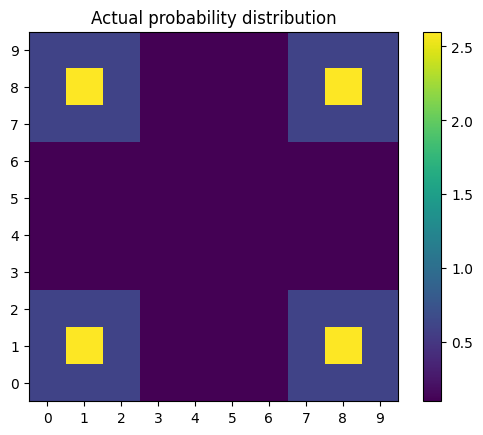

<Figure size 640x480 with 0 Axes>

In [21]:
axis = np.arange(gridLength)


plt.xticks(axis, labels=axis.astype(str))
plt.yticks(axis, labels=axis.astype(str))

# To plot the default distribution replace rewardFunction with MCMC.grid_rewards_2d.
plt.imshow(MCMC.grid_rewards_2d(gridLength = gridLength), cmap='viridis')
plt.colorbar()
plt.gca().set_title("Actual probability distribution")
plt.gca().invert_yaxis()
plt.show()
plt.clf()

## The generated distributions.

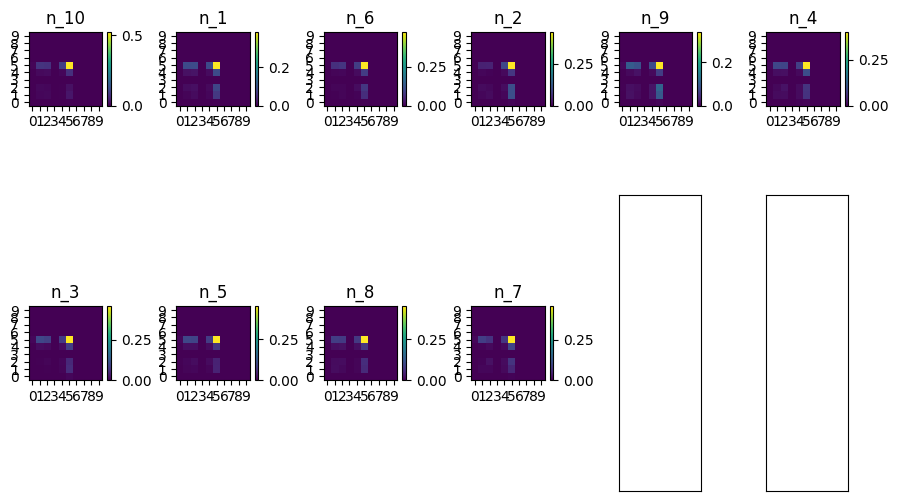

<Figure size 640x480 with 0 Axes>

In [10]:
dir = "data/2DComparison/iterations_"+str(iterationsNumber)+"_batch_size_"+str(batchSize)+"_burnin_"+str(burnFactor)+"_sigma_"+str(deviation)+"/gridLength"+str(gridLength)+"/draws/"

fileNumber = 0

for file in Path(dir).glob("**/*draw*"):
    fileNumber += 1

rows = 1

while(fileNumber % rows != 0):
    rows += 1

axis = np.arange(gridLength)

fig, axs = plt.subplots(nrows=math.ceil(fileNumber / 6.0), ncols=6, figsize=(9, 6), subplot_kw={'xticks': [], 'yticks': []})


for ax, file in zip(axs.flat, Path(dir).glob("**/*draw*")):
    df = np.genfromtxt(file, delimiter=',', skip_header=1)
    df = np.array(df)
    data = np.zeros(shape=(gridLength, gridLength))
    batchNumber = float(np.sum(df[:,2]))
    for i in range(df.shape[0]):
        data[int(df[i, 0]), int(df[i, 1])] += df[i, 2] / batchNumber
    
    title = str(os.path.basename(file).split("batch_",1)[1]) # Remove part beofre batch number
    title = title.split(".csv")[0] # Remove the ending
    ax.set_title(title)
    ax.set_xticks(axis, labels=axis.astype(str))
    ax.set_yticks(axis, labels=axis.astype(str))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(ax.imshow(data, cmap='viridis', interpolation='nearest'), cax = cax)
    ax.invert_yaxis()


plt.tight_layout()
plt.show()
plt.clf()



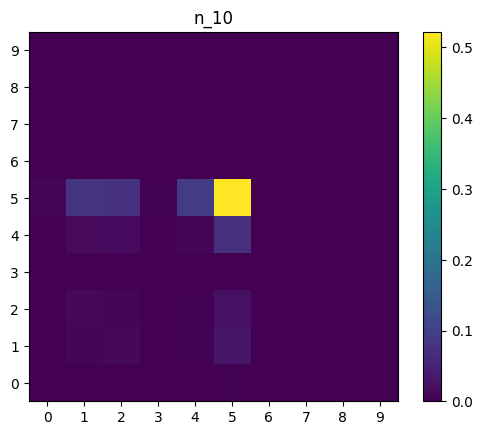

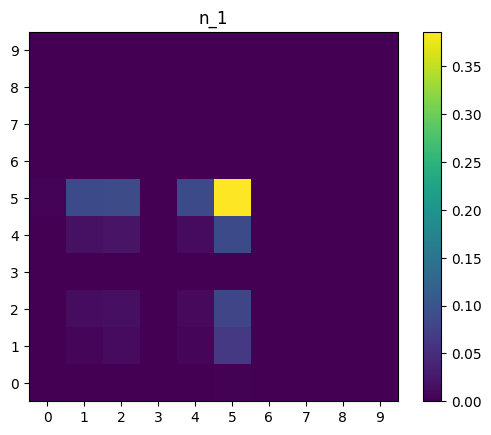

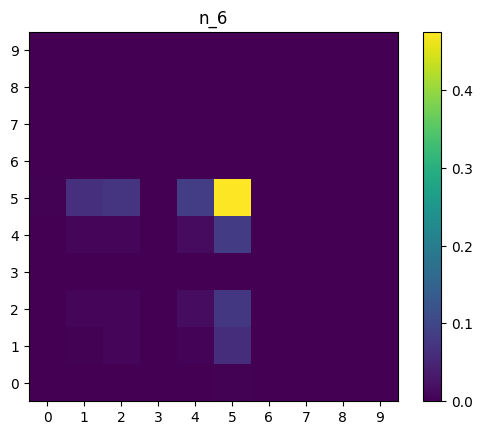

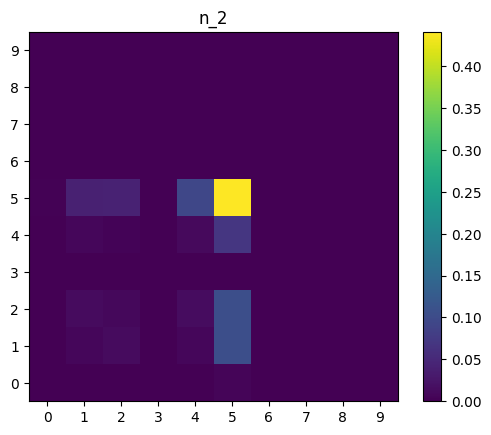

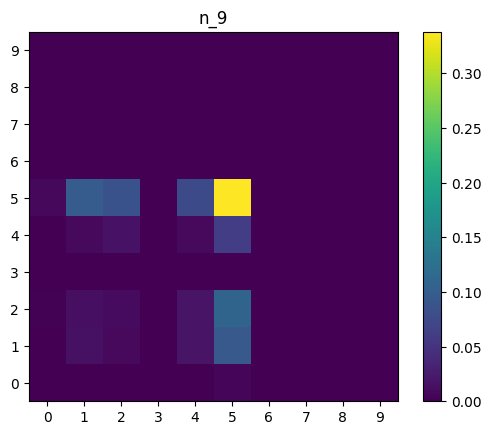

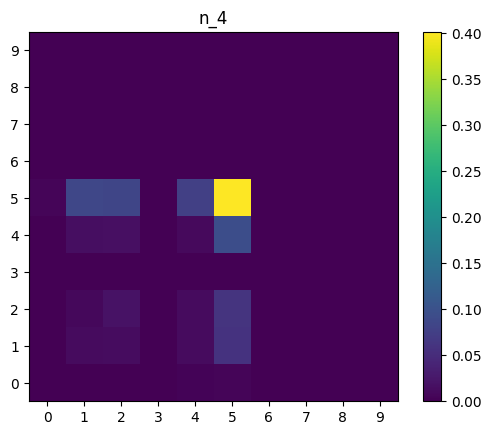

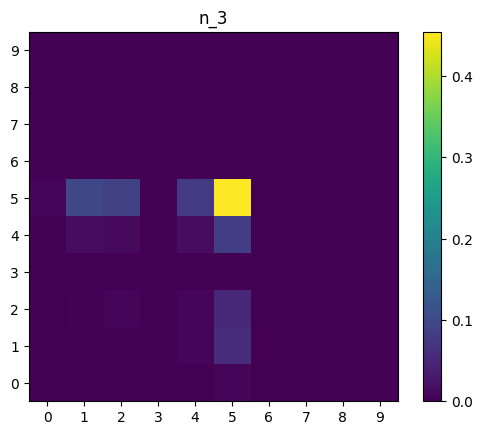

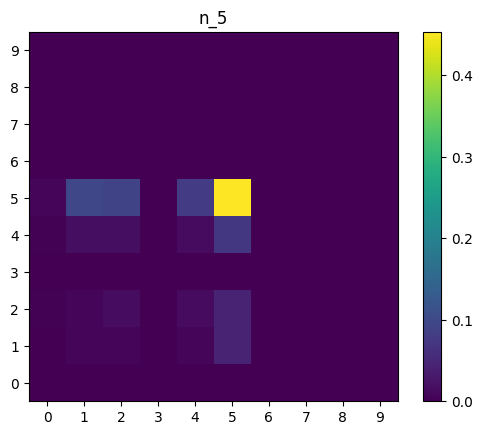

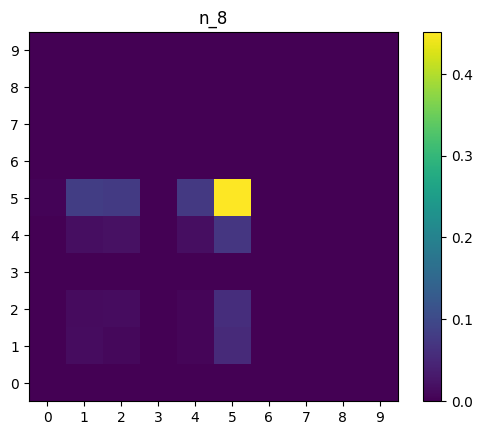

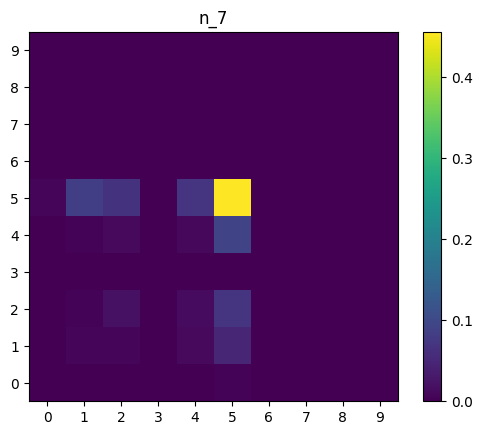

<Figure size 640x480 with 0 Axes>

In [11]:
dir = "data/2DComparison/iterations_"+str(iterationsNumber)+"_batch_size_"+str(batchSize)+"_burnin_"+str(burnFactor)+"_sigma_"+str(deviation)+"/gridLength"+str(gridLength)+"/draws/"

fileNumber = 0

for file in Path(dir).glob("**/*draw*"):
    fileNumber += 1



axis = np.arange(gridLength)

for file in Path(dir).glob("**/*draw*"):
    df = np.genfromtxt(file, delimiter=',', skip_header=1)
    df = np.array(df)
    data = np.zeros(shape=(gridLength, gridLength))
    batchNumber = float(np.sum(df[:,2]))

    for i in range(df.shape[0]):
        data[int(df[i, 0]), int(df[i, 1])] += df[i, 2]/batchNumber
    plt.xticks(axis, labels=axis.astype(str))
    plt.yticks(axis, labels=axis.astype(str))
    title = str(os.path.basename(file).split("batch_",1)[1]) # Remove part beofre batch number
    title = title.split(".csv")[0] # Remove the ending
    plt.imshow(data, cmap='viridis')
    plt.colorbar()
    plt.gca().set_title(str(title))
    plt.gca().invert_yaxis()
    plt.show()
    plt.clf()
    
    

